In [ ]:
# tutorial not ready

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.stats
import scipy.io
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import maximum_filter1d
from scipy.ndimage.filters import minimum_filter1d
from six.moves import urllib
import os
import sklearn.decomposition
import warnings
warnings.simplefilter('ignore')

In [ ]:
# DATA preprocessing
# we need to clean up the pupil data
# we need to baseline and deconvolve the calcium fluorescence data

In [ ]:
# clean up pupil data: find outliers and replace them by interpolation

In [ ]:
from scipy.ndimage import filters

# baseline fluorescence traces recorded with 2p calcium imaging
ops['sig_baseline'] = 1  # adjust this to get desired result
ops['win_baseline'] = 20 # adjust this to get desired result
ops['fs'] = 5

sig = ops['sig_baseline']
win = int(ops['win_baseline']*ops['fs'])    

# smooth the data first, to remove high-frequency noise
Flow = filters.gaussian_filter(F,    [0., sig])

# now run a minimum filter
Flow = filters.minimum_filter1d(Flow,    win)

# now run a maximum filter
Flow = filters.maximum_filter1d(Flow,    win)

In [ ]:
# visualize the baseline for neuron iN
iN = 100
timerange = np.arange(0, 1000)
plt.figure(figsize=(12,4))
plt.plot(F[iN,timerange])
plt.plot(Flow[iN,timerange])
plt.show()

In [ ]:
# once we're happy with the parameters, run the baselined data through deconvolution
from suitep import dcnv

ops['tau'] = 2. # timescale of gcamp sensor
F0 = F - Flow
sp = dcnv.oasis(F - Flow, ops) # deconvolve the baselined traces using OASIS

In [ ]:
# reconstruct the fluorescence from the deconvolved using the exponential convolution filter
flt = exp(-np.arange(0,ops['fs']*10)/ops['tau'])
Frec = np.convolve(sp, flt)

In [ ]:
# visualize the reconstruction for neuron iN
iN = 100
timerange = np.arange(0, 1000)

plt.figure(figsize=(12,4))
plt.plot(Frec[iN,timerange])
plt.plot(F0[iN,timerange])
plt.show()

In [ ]:
# ready to build some models! 
# use T consecutive samples to predict the T+1-th sample

# normalize spike data
# subtract mean for each neuron
sp  = sp - sp.mean(axis=1)[:,np.newaxis]
# divide by the global standard deviation
sp = sp/np.std(sp)

# we will do this prediction one neuron at a time
iN = 100

# let's make windows of size k (where k is how much history we consider)
k = 10
x = np.zeros((nt-k-1,k+1))
for n in range(nt-k-1):
    x[n,:] = sp[iN, n:n+k+1]
    
# we predict the last sample
y = x[:, k]
# from the first k samples
x = x[:, :k]

# for regression we need the covariance of the inputs
covX = x.T @ x / x.shape[0]
# and the cross-covariance between output and input
xty = x.T @ y / x.shape[0]

# linalg.solve(a,b) solves the equations aw = b, so w = a^-1 * b, which is the solution to our regression problem
w = np.linalg.solve(covX, xty)

In [ ]:
# now let's plotthe filter w, the raw data, and the prediction

# we will make a small function that computes the variance explained
def variance_explained(y,x,w):
    ypred = x @ w
    varres = ((y - ypred)**2).mean()
    varexp = 1 - varres / y[:-1].var()
    return varexp

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1,2,1)
ax.plot(w)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(y[:500])
ax2.plot(x[:500,:] @ w)
plt.show()

print('variance explained is %2.2f'%(variance_explained(y,x,w))

In [ ]:
# that didn't work so well. let's combine it with PCA.
# decompose data into PCs, predict the PCs, and then recombine the predictions.
# are we doing better? 

# compute principal components
nPCs = 100 # how many PCs to keep
sv,u  = scipy.sparse.linalg.eigsh(sp @ sp, k=nPCs)

# project data into PCs
tracePC = u.T @ sp

# to reconstruct the data and predictions ,we will do
# sp_rec = u @ tracePC

# the following simply copies the code from above, in a loop for each PC
tracePCrec = np.zeros(tracePC.shape) # preallocate reconstructed traces
for iN in range(nPCs):
    k = 10
    # let's make windows of size k (where k is how much history we consider)
    x = np.zeros((nt-k-1,k+1))
    for n in range(nt-k-1):
        x[n,:] = tracePC[iN, n:n+k+1]
    # we predict the last sample
    y = x[:, k]
    # from the first k samples
    x = x[:, :k]
    # for regression we need the covariance of the inputs
    covX = x.T @ x / x.shape[0]
    # and the cross-covariance between output and input
    xty = x.T @ y / x.shape[0]
    # linalg.solve(a,b) solves the equations aw = b, so w = a^-1 * b, which is the solution to our regression problem
    w = np.linalg.solve(covX, xty)
    # what is the reconstruction of the PC
    tracePCrec[iN, :] = x @ w

In [ ]:
# now that we have PC predictions, let's reconstruct single neuron predictions
sp_rec = u @ tracePCrec

iN = 100
y = sp[iN,:]
x = sp_rec[iN,:]

print('variance explained is %2.2f'%)

# make a loop to compute explained variance per neuron and plot it across neurons

In [ ]:
# can we reconstruct the single neuron filters, based on the PC filters? 

# how about using this to predict one neuron from other neurons? can we reconstruct those filters?

In [ ]:
# how many timesamples in the past do we need? make AR(1), AR(2) models. 

# go back above and replace k with 1, 2, 3, etc where does prediction saturate? 

In [ ]:
# Try basis functions instead with timescales of .5, 1, 2, 4 and 8 frames. 
# filter the PCs with exponential filters, predict from those
# no need to window anymore for this: each exponential filter should be applied convolutionally


In [ ]:
# check out the filters learnt: reconstruct them with the basis functions



In [ ]:
# now let's see if we can predict a PC from other PCs. why would we even try this if the PCs are orthogonal?

In [ ]:
# add pupil information. First predict only from the pupil, then try basis functions on the pupil

In [2]:
# let's put it all together! predict each PC at time T+1 from all pupil coefficients, 
# same PC coefficients and all other PC coefficients

In [1]:
# create dataset and discrete classification
# y = x + gaussian random noise
# => latent variable is identity line
N = 100
x = np.random.random((N,))
y = x + .2*np.random.randn(N)

x = np.vstack((x,y))
cm = np.array([[1,0,0],[0,0,1]])
cms = np.zeros((N,3))
cms[x[0,:]>.5,:] = cm[0,:]
cms[x[0,:]<=.5,:] = cm[1,:]

# download 2-photon data (if not already downloaded)
if not os.path.isfile('data/mesoscope_activity.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    response = urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscope_activity.npy');
    f=open('data/mesoscope_activity.npy','wb')
    f.write(response.read())
    f.close()
    
# load downloaded data
dat = np.load('data/mesoscope_activity.npy')
dat = dat.item()
sp  = dat['spks']
xyloc = dat['xyloc']

In [447]:
dat = scipy.io.loadmat('D:/grive/10krecordings/spontData/spont_M150824_MP019_2016-04-05.mat', squeeze_me=True)


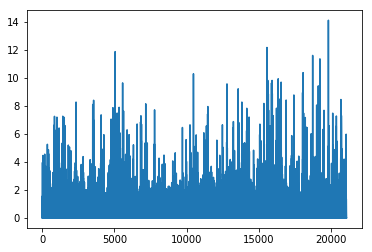

In [457]:
f = dat['Fsp'][10,:]
sp = dat['Fsp']
# normalize stddev's of cells
sp /= sp.std(axis=1)[:,np.newaxis]
plt.plot(f)
plt.show()

In [290]:
m1 = scipy.io.loadmat('../lecture_2/data/m1_stevenson_2011.mat', squeeze_me=True)
sp = m1['spikes']
m1['time'] = m1['time'].squeeze()
tbin = np.diff(m1['time']).mean()
handpos = m1['handPos']

In [449]:
# sp is neurons x timepts, find first PC
# mean center data
sp_sub  = sp - sp.mean(axis=1)[:,np.newaxis]
# compute principal components
sv,u  = scipy.sparse.linalg.eigsh(sp_sub @ sp_sub.T,k=100)
v = np.diag(sv**-0.5) @ u.T @ sp_sub
# low-dimensional approximation:
sp_lowd = ((sp_sub.T @ u) @ u.T).T

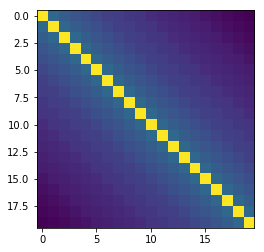

In [430]:
# the covariance in time is a circulant matrix which reflects the autocorrelation function
plt.imshow(covX)
plt.show()

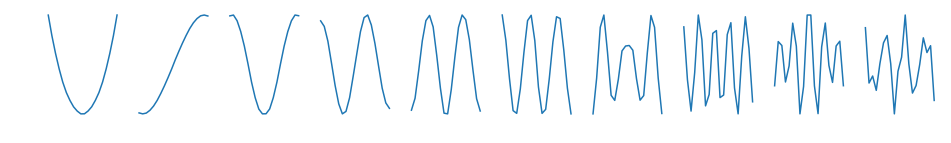

In [431]:
# circulant matrices have PCs which are Fourier modes
svx,ux = scipy.sparse.linalg.eigsh(covX,k=covX.shape[1])
fig = plt.figure(figsize=(16,2))
for k in range(10):
    ax = fig.add_subplot(1,10,k+1)
    ax.plot(ux[:,ux.shape[1]-1-k])
    ax.axis('off')

In [480]:
from scipy.ndimage.filters import convolve1d

expfilt = np.exp(np.arange(0,-8,-1)/2)
#expfilt /= expfilt.sum()
# filter each neuron's timecourse with an exponential filter
spexp = convolve1d(sp, expfilt, axis=1)

(11983, 21055)


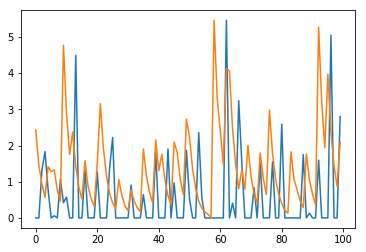

In [481]:
plt.plot(sp[1,:100])
plt.plot(spexp[1,:100])
print(spexp.shape)